In [12]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import TimestampType, IntegerType, DoubleType
import pyspark.sql.functions as F
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


import matplotlib.pyplot as plt
import seaborn as sns


## Инициализация pyspark

In [13]:
MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

filename_data = '1.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data, header=True, inferSchema=True, sep=';')
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# Выполните разведочный анализ датасета с определением

## типов признаков в датасете;

### Numerical (Numerical/Time Series):

* actual_consumption
* actual_pv
* load_00, load_01, ..., load_95
* pv_00, pv_01, ..., pv_95


### Time-Related (Time Series):

* timestamp: Represents the time step for each row.

In [14]:
# Get column names and data types as a list of tuples
# Print schema for the entire DataFrame
print('Data overview')
df.printSchema()

# Select a subset of columns for overview
selected_columns = ["timestamp", "site_id", "period_id", "actual_consumption", "actual_pv",
                    "load_00", "load_01", "load_02", "load_03", "load_04", "load_05",
                    "pv_00", "pv_01", "pv_02", "pv_03", "pv_04", "pv_05"]

# Create a new DataFrame with the selected columns
df_short = df.select(selected_columns)

# Display the data types of the selected columns
print('Columns overview')
df_short.printSchema()

Data overview
root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (n

In [15]:
# Define column names and data types
columns = [
    ("timestamp", TimestampType()),
    ("site_id", IntegerType()),
    ("period_id", IntegerType()),
    ("actual_consumption", DoubleType()),
    ("actual_pv", DoubleType()),
    ("load_00", DoubleType()),
    ("load_01", DoubleType()),
    ("load_02", DoubleType()),
    ("load_03", DoubleType()),
    ("load_04", DoubleType()),
    ("load_05", DoubleType()),
    ("pv_00", DoubleType()),
    ("pv_01", DoubleType()),
    ("pv_02", DoubleType()),
    ("pv_03", DoubleType()),
    ("pv_04", DoubleType()),
    ("pv_05", DoubleType())
]

# Apply the schema to the PySpark DataFrame
for col, data_type in columns:
    df = df.withColumn(col, df['`{}`'.format(col)].cast(data_type))

# Select specific columns from the DataFrame
selected_columns = ["timestamp", "site_id", "period_id", "actual_consumption", "actual_pv",
                    "load_00", "load_01", "load_02", "load_03", "load_04", "load_05",
                    "pv_00", "pv_01", "pv_02", "pv_03", "pv_04", "pv_05"]

selected_df = df.select(*selected_columns)

# Display the schema to see the types of features in the dataset
print('DataFrame Schema:')
selected_df.printSchema()

# Display the first few rows of the DataFrame
print('First Few Rows:')
selected_df.show()

DataFrame Schema:
root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- pv_00: double (nullable = true)
 |-- pv_01: double (nullable = true)
 |-- pv_02: double (nullable = true)
 |-- pv_03: double (nullable = true)
 |-- pv_04: double (nullable = true)
 |-- pv_05: double (nullable = true)

First Few Rows:
+-------------------+-------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+----------------

## пропущенных значений и их устранением;

In [16]:
# Show missing values
print('Missing values before handling:')
selected_df.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in selected_df.columns]).show()

# Define conditions for filtering zeros and negative numbers
conditions = (
    (F.col("actual_consumption") > 0) &
    (F.col("actual_pv") > 0) &
    (F.col("load_00") > 0) &
    (F.col("load_01") > 0) &
    (F.col("load_02") > 0) &
    (F.col("load_03") > 0) &
    (F.col("load_04") > 0) &
    (F.col("load_05") > 0) &
    (F.col("pv_00") > 0) &
    (F.col("pv_01") > 0) &
    (F.col("pv_02") > 0) &
    (F.col("pv_03") > 0) &
    (F.col("pv_04") > 0) &
    (F.col("pv_05") > 0)
)

# Apply the filter to the DataFrame
filtered_df = selected_df.filter(conditions)

# Show the resulting DataFrame
filtered_df.show()

# Display the count of removed rows
removed_rows_count = selected_df.count() - filtered_df.count()
print(f'Number of removed rows: {removed_rows_count}')

Missing values before handling:
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+-----+-----+-----+-----+-----+-----+
|timestamp|site_id|period_id|actual_consumption|actual_pv|load_00|load_01|load_02|load_03|load_04|load_05|pv_00|pv_01|pv_02|pv_03|pv_04|pv_05|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+-----+-----+-----+-----+-----+-----+
|        0|      0|        0|                 0|        0|      0|      0|      0|      0|      0|      0|    0|    0|    0|    0|    0|    0|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+-----+-----+-----+-----+-----+-----+
+-------------------+-------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+--

## выбросов и их устранением;

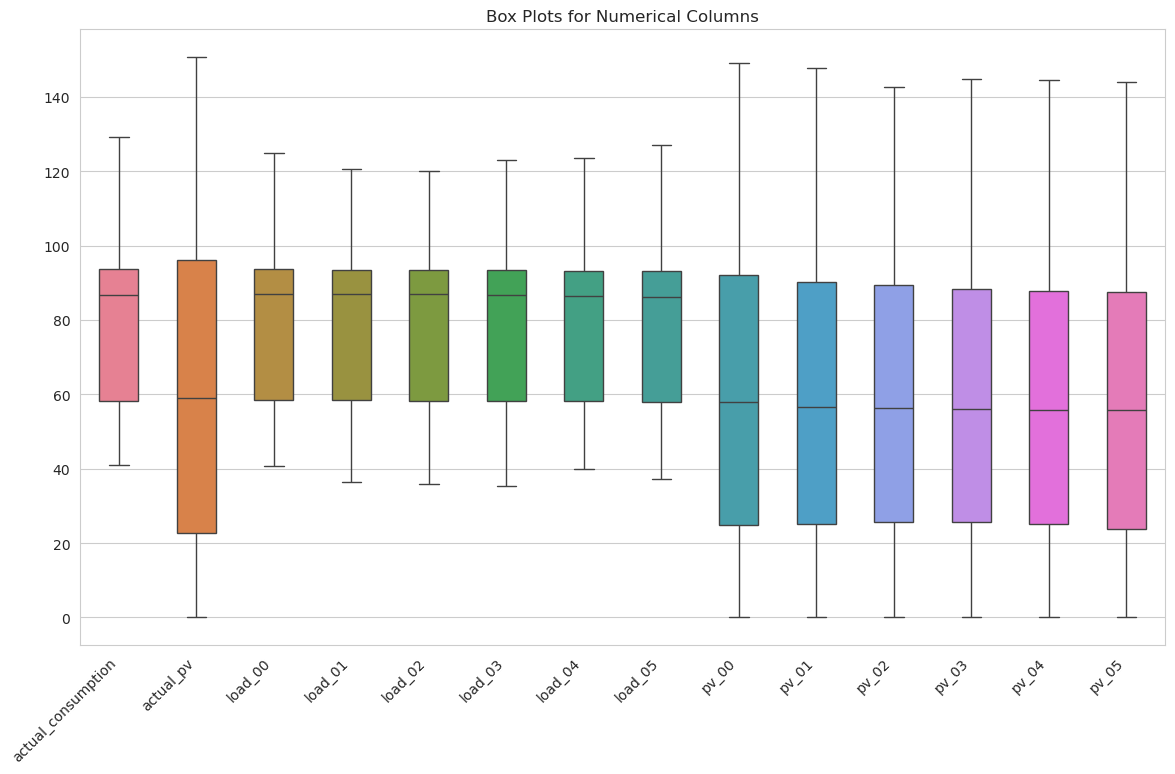

In [17]:
# Specify the columns for box plots
numerical_columns = ["actual_consumption", "actual_pv", "load_00", "load_01", "load_02", "load_03", "load_04", "load_05",
                     "pv_00", "pv_01", "pv_02", "pv_03", "pv_04", "pv_05"]

# Calculate quantiles and interquartile range for each column
for column in numerical_columns:
    first_quantile = filtered_df.approxQuantile(column, [0.25], 0)[0]
    third_quantile = filtered_df.approxQuantile(column, [0.75], 0)[0]
    interquartile_half_range = (third_quantile - first_quantile) / 2
    lower = first_quantile - (2 * interquartile_half_range)
    upper = third_quantile + (2 * interquartile_half_range)

    # Filter the DataFrame based on quantiles
    filtered_df = filtered_df.filter((filtered_df[column] > lower) & (filtered_df[column] < upper))

# Collect data to the local machine for plotting
data_for_plotting = filtered_df.select(*numerical_columns).collect()

# Prepare data for box plots
box_plot_data = {col_name: [row[col_name] for row in data_for_plotting] for col_name in numerical_columns}

# Generate box plots using seaborn
plt.figure(figsize=(14, 8))
sns.boxplot(data=box_plot_data, width=0.5)
plt.title("Box Plots for Numerical Columns")
plt.xticks(rotation=45, ha="right")
plt.show()

In [18]:
# Specify the columns where you want to handle outliers (assuming these are numeric columns)
numerical_columns = ["actual_consumption", "actual_pv", "load_00", "load_01", "load_02", "load_03", "load_04", "load_05",
                     "pv_00", "pv_01", "pv_02", "pv_03", "pv_04", "pv_05"]

# Show the total number of rows after handling outliers
print('Rows count before handling outliers:', filtered_df.count())

# Define the lower and upper limits based on 3 standard deviations from the mean
std_dev_limits = {col_name: 3 * filtered_df.agg({col_name: "stddev"}).collect()[0][0] for col_name in numerical_columns}
mean_values = {col_name: filtered_df.agg({col_name: "mean"}).collect()[0][0] for col_name in numerical_columns}

# Filter the data, keeping only the rows where values are within 3 standard deviations from the mean
for col_name in numerical_columns:
    lower_limit = mean_values[col_name] - std_dev_limits[col_name]
    upper_limit = mean_values[col_name] + std_dev_limits[col_name]
    filtered_df = filtered_df.filter((filtered_df[col_name] >= lower_limit) & (filtered_df[col_name] <= upper_limit))

# Show the total number of rows after handling outliers
print('Rows count after handling outliers:', filtered_df.count())

Rows count before handling outliers: 21467
Rows count after handling outliers: 21467


## расчетом статистических показателей признаков;


In [19]:
# Specify the columns for which you want to calculate statistics
numerical_columns = ["actual_consumption", "actual_pv", "load_00", "load_01", "load_02", "load_03", "load_04", "load_05",
                     "pv_00", "pv_01", "pv_02", "pv_03", "pv_04", "pv_05"]

# Calculate statistical measures using the describe method
statistics_df = filtered_df.describe(numerical_columns)

# Show the calculated statistics
statistics_df.show(truncate=False)

+-------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|actual_consumption|actual_pv           |load_00           |load_01           |load_02           |load_03           |load_04           |load_05           |pv_00               |pv_01               |pv_02               |pv_03               |pv_04               |pv_05               |
+-------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|count  |21467             |21467               |21467             |21467             |21467             |21467             |21467

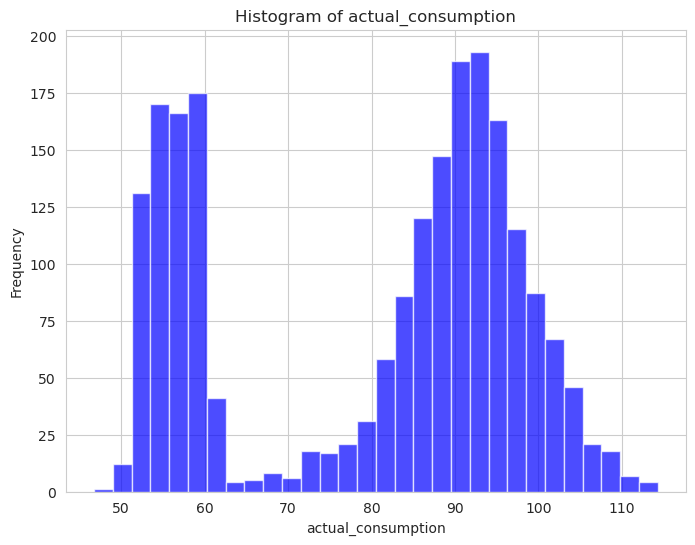

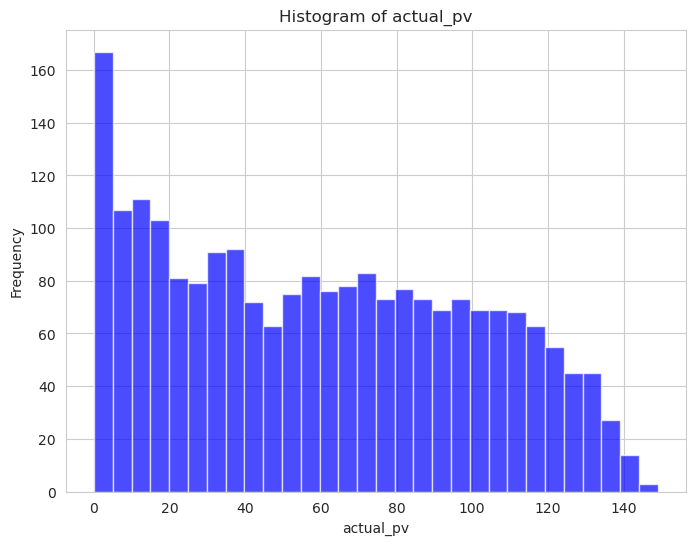

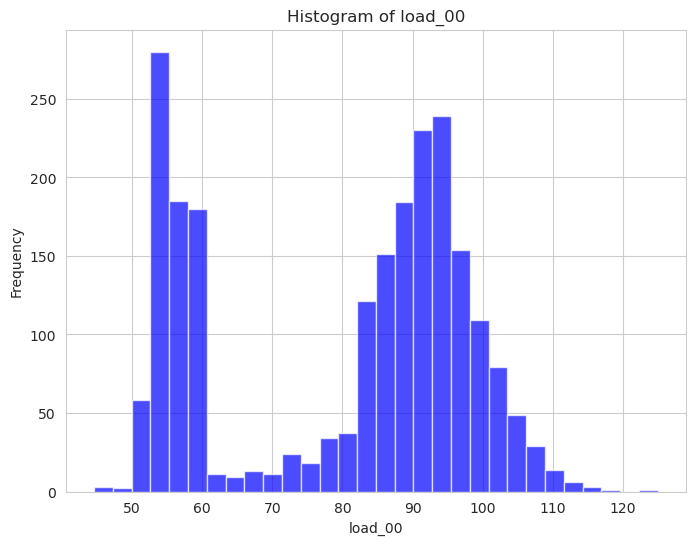

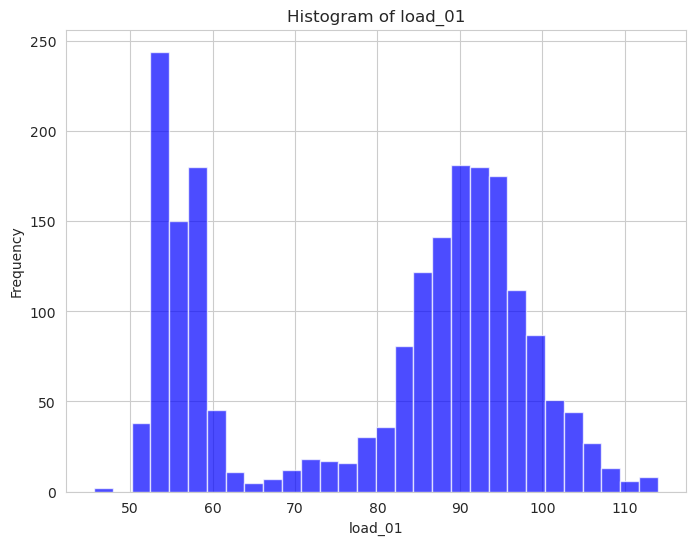

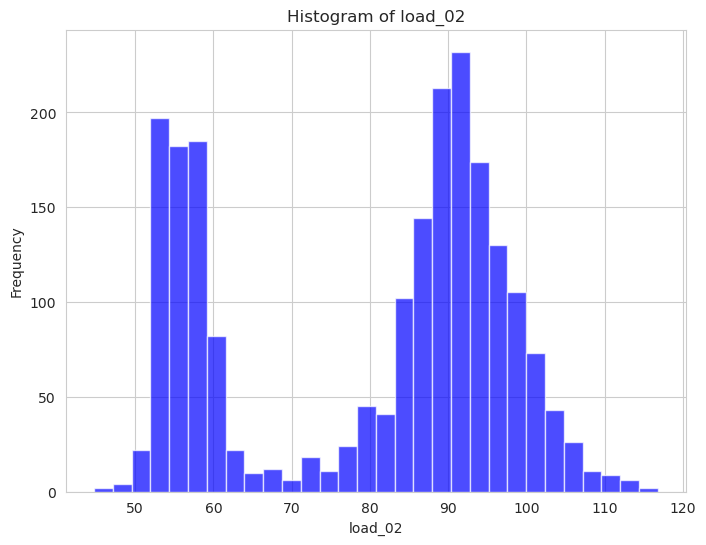

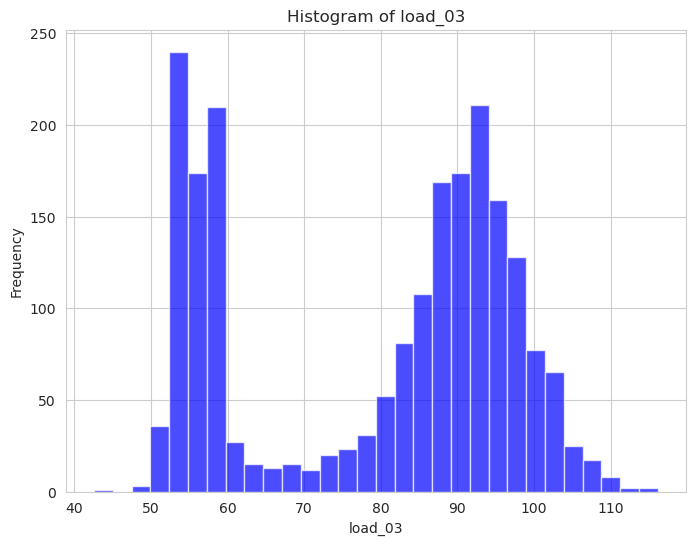

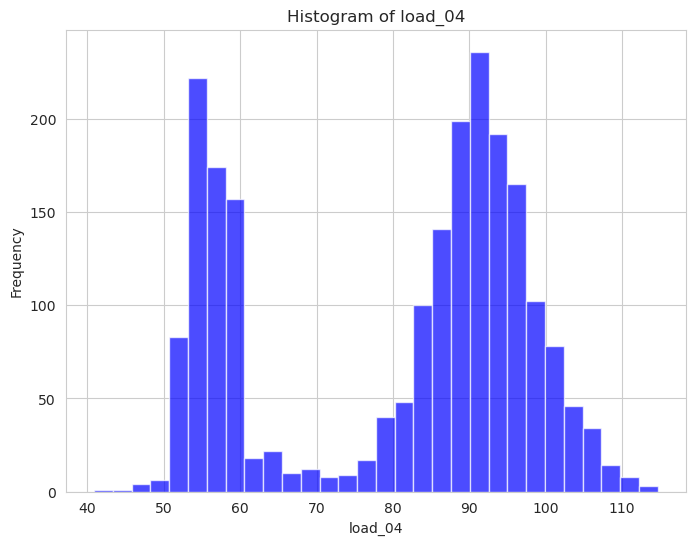

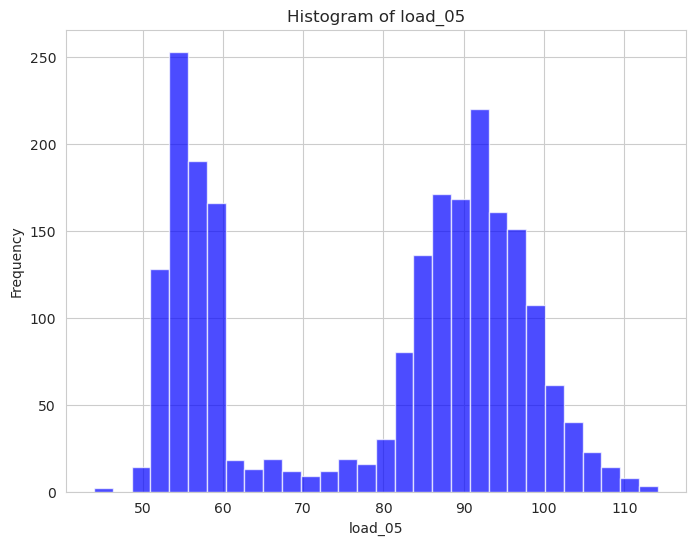

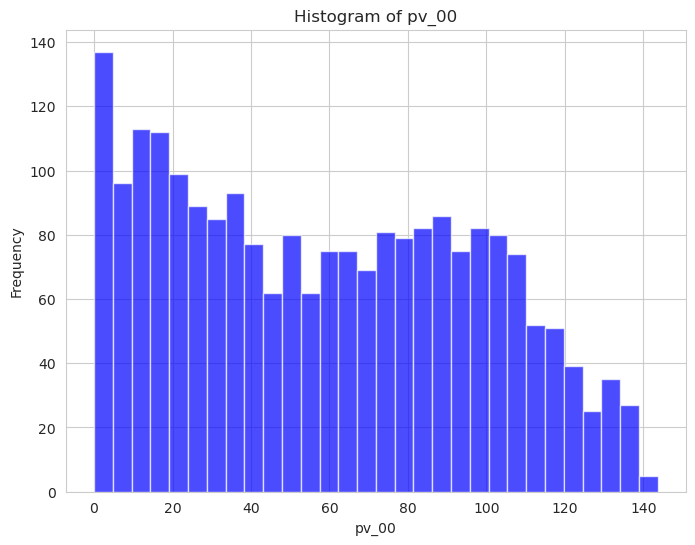

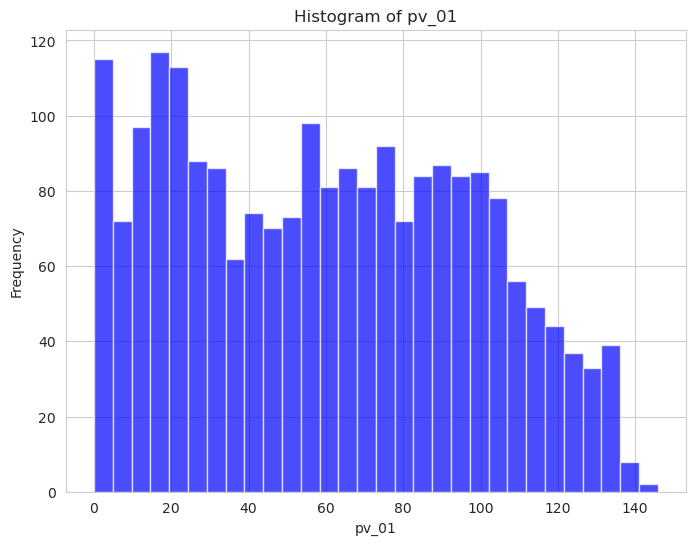

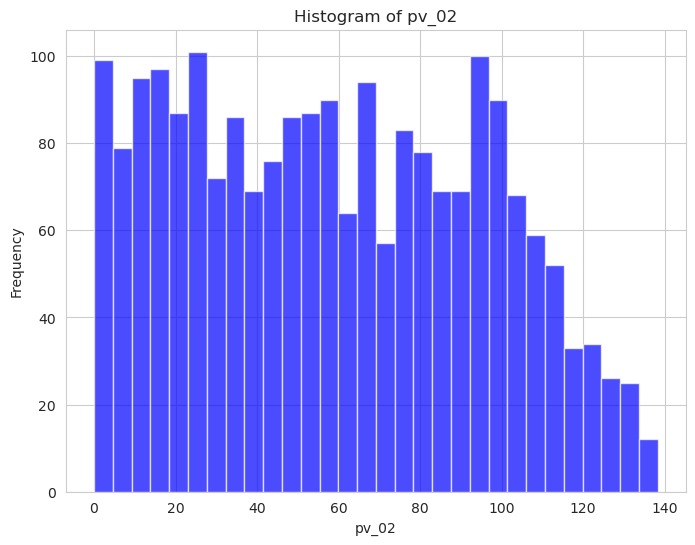

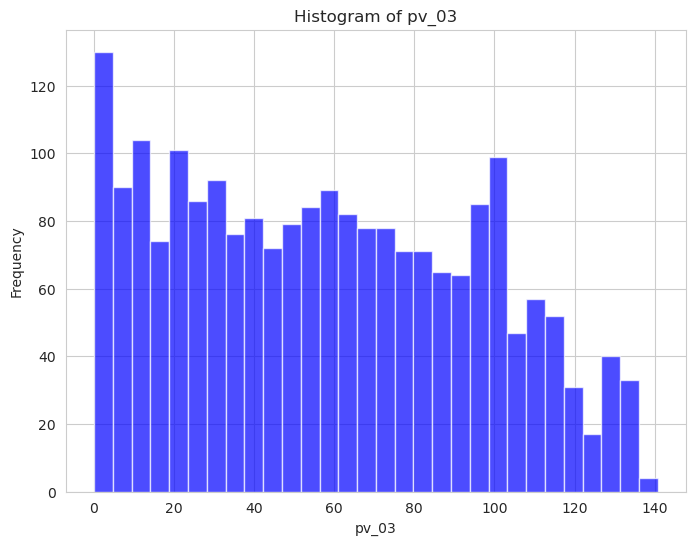

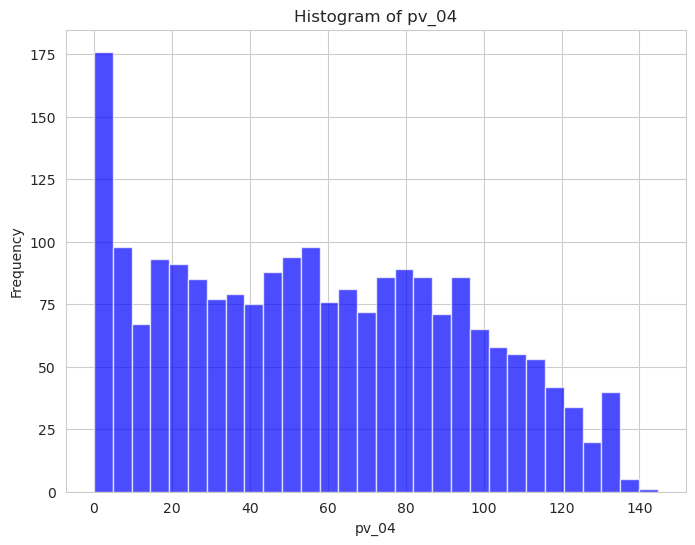

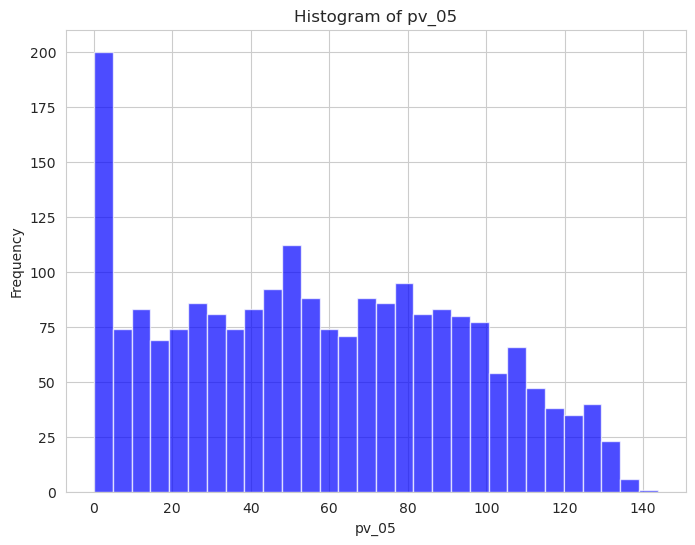

In [20]:
# Specify the numerical columns for which you want to create histograms
numerical_columns = ["actual_consumption", "actual_pv", "load_00", "load_01", "load_02", "load_03", "load_04", "load_05",
                     "pv_00", "pv_01", "pv_02", "pv_03", "pv_04", "pv_05"]

# Plot histograms
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(filtered_df.select(column).sample(False, 0.1).rdd.flatMap(lambda x: x).collect(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

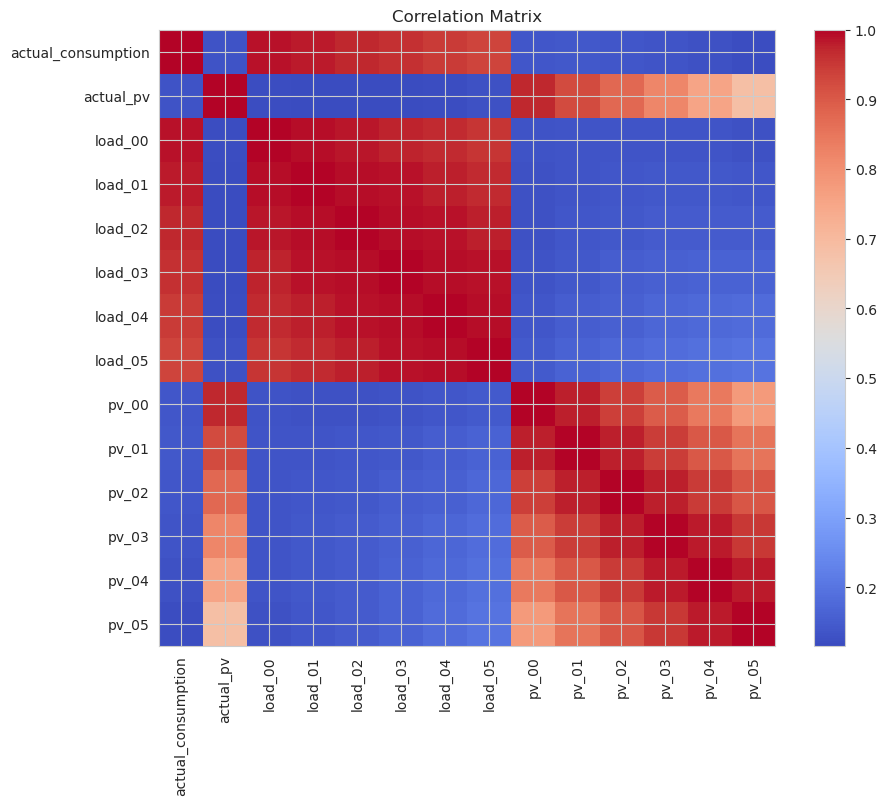

In [21]:
# Specify the numerical columns for correlation
numerical_columns = ["actual_consumption", "actual_pv", "load_00", "load_01", "load_02", "load_03", "load_04", "load_05",
                     "pv_00", "pv_01", "pv_02", "pv_03", "pv_04", "pv_05"]

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
assembled_df = assembler.transform(filtered_df)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").head()

# Extract the correlation matrix as a array
corr_matrix = correlation_matrix[0].toArray()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar()
plt.xticks(range(len(numerical_columns)), numerical_columns, rotation=90)
plt.yticks(range(len(numerical_columns)), numerical_columns)
plt.title("Correlation Matrix")
plt.show()

In [22]:
# Останавливаем сессию Spark
spark.stop()